1. На основе учебного ноутбука проведите финальную подготовку данных. Иизмените количество сегментирующих классов с `16` на `5`.

2. Проведите суммарно не менее `10` экспериментов и визуализируйте их результаты (включая точность обучения сетей на одинаковом количестве эпох, например, на `7`):

  - изменив `filters` в сверточных слоях
  - изменив `kernel_size` в сверточных слоях
  - изменив активационную функцию в скрытых слоях с `relu` на `linear` или/и `selu`, `elu`.


**Важно!**

Многие эксперименты могут приводить к переполнению ОЗУ в вашем ноутбуке и сброса кода обучения.

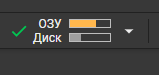



Для предотвращения переполнения ОЗУ может помочь библиотека `gc`. Вставьте строчку `gc.collect()` в цикл ваших экспериментов для сбора и удаления временных данных (кеш).

Перед выполнением задания, пожалуйста, запустите ячейку `Подготовка` ниже:

## Подготовка

### Импорт библиотек

In [ ]:
 # Импортируем модели keras: Model
from tensorflow.keras.models import Model

 # Импортируем стандартные слои keras
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation
from tensorflow.keras.layers import MaxPooling2D, Conv2D, BatchNormalization, UpSampling2D

# Импортируем оптимизатор Adam
from tensorflow.keras.optimizers import Adam

# Импортируем модуль pyplot библиотеки matplotlib для построения графиков
import matplotlib.pyplot as plt

# Импортируем модуль image для работы с изображениями
from tensorflow.keras.preprocessing import image

# Импортируем библиотеку numpy
import numpy as np

# Импортируем методделения выборки
from sklearn.model_selection import train_test_split

# загрузка файлов по HTML ссылке
import gdown

# Для работы с файлами
import os

# Для генерации случайных чисел
import random

import time

# импортируем модель Image для работы с изображениями
from PIL import Image

# очистка ОЗУ
import gc

### Загрузка датасета

грузим и распаковываем архив картинок

In [ ]:
# Загрузка датасета из облака

gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip', None, quiet=False)
#gdown.download('https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_512x384.zip', None, quiet=False)

!unzip -q 'construction_256x192.zip' # распоковываем архив

Downloading...
From: https://storage.yandexcloud.net/aiueducation/Content/base/l14/construction_256x192.zip
To: /content/construction_256x192.zip
100%|██████████| 214M/214M [00:09<00:00, 21.8MB/s]


In [ ]:
# Глобальные параметры

IMG_WIDTH = 256               # Ширина картинки
IMG_HEIGHT = 192              # Высота картинки
NUM_CLASSES = 16              # Задаем количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

Загрузим оригинальные изображения (код из лекции):

In [ ]:
train_images = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_images = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time()  # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_images.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/original',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающей выборке
print ('Количество изображений: ', len(train_images))

cur_time = time.time() # Засекаем текущее время

# Проходим по всем файлам в каталоге по указанному пути
for filename in sorted(os.listdir(VAL_DIRECTORY+'/original')):
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_images.append(image.load_img(os.path.join(VAL_DIRECTORY+'/original',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочной выборке
print ('Количество изображений: ', len(val_images))

Обучающая выборка загружена. Время загрузки: 0.7c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.03c
Количество изображений:  100


Загрузим сегментированные изображения (код из лекции):

In [ ]:
train_segments = [] # Создаем пустой список для хранений оригинальных изображений обучающей выборки
val_segments = [] # Создаем пустой список для хранений оригинальных изображений проверочной выборки

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(TRAIN_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    train_segments.append(image.load_img(os.path.join(TRAIN_DIRECTORY+'/segment',filename),
                                       target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок обучающей выборки
print ('Обучающая выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в обучающем наборе сегментированных изображений
print ('Количество изображений: ', len(train_segments))

cur_time = time.time() # Засекаем текущее время

for filename in sorted(os.listdir(VAL_DIRECTORY+'/segment')): # Проходим по всем файлам в каталоге по указанному пути
    # Читаем очередную картинку и добавляем ее в список изображений с указанным target_size
    val_segments.append(image.load_img(os.path.join(VAL_DIRECTORY+'/segment',filename),
                                     target_size=(IMG_WIDTH, IMG_HEIGHT)))

# Отображаем время загрузки картинок проверочной выборки
print ('Проверочная выборка загружена. Время загрузки: ', round(time.time() - cur_time, 2), 'c', sep='')

# Отображаем количество элементов в проверочном наборе сегментированных изображений
print ('Количество изображений: ', len(val_segments))

Обучающая выборка загружена. Время загрузки: 0.66c
Количество изображений:  1900
Проверочная выборка загружена. Время загрузки: 0.03c
Количество изображений:  100


## Решение


In [ ]:
# Решение

In [ ]:
# Функция для обработки сегментов
def process_segment(segments):
    processed = []
    for seg in segments:
        seg_array = np.array(seg)
        if seg_array.ndim == 3:
            seg_array = seg_array[:, :, 0]  # Берем первый канал если изображение RGB
        seg_array = seg_array % NUM_CLASSES  # Преобразуем метки в диапазон 0-4
        processed.append(seg_array)
    return processed

# Обработка сегментов
train_segments = process_segment(train_segments)
val_segments = process_segment(val_segments)

# Преобразование изображений и меток в numpy массивы
X_train = np.array([image.img_to_array(img)/255.0 for img in train_images])
y_train = np.array([seg for seg in train_segments], dtype=np.uint8)
X_val = np.array([image.img_to_array(img)/255.0 for img in val_images])
y_val = np.array([seg for seg in val_segments], dtype=np.uint8)

In [ ]:
# Модифицированная функция U-Net с полной параметризацией
def masked_unet(class_count, input_shape, filters_list, kernel_size=(3,3), activation='relu'):
    img_input = Input(input_shape)
    # Добавлена проверка kernel_size
    if isinstance(kernel_size, list):
        assert len(kernel_size) == 5, "kernel_size list must have 5 elements"
    else:
        kernel_size = [kernel_size]*5
    # Block 1
    x = Conv2D(filters_list[0], kernel_size[0], padding='same', name='block1_conv1')(img_input)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[0], kernel_size[0], padding='same', name='block1_conv2')(x)
    x = BatchNormalization()(x)
    block_1_out = Activation(activation)(x)
    block_1_out_mask = Conv2D(filters_list[0], (1,1), padding='same')(block_1_out)
    x = MaxPooling2D()(block_1_out)

    # Block 2
    x = Conv2D(filters_list[1], kernel_size[1], padding='same', name='block2_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[1], kernel_size[1], padding='same', name='block2_conv2')(x)
    x = BatchNormalization()(x)
    block_2_out = Activation(activation)(x)
    block_2_out_mask = Conv2D(filters_list[1], (1,1), padding='same')(block_2_out)
    x = MaxPooling2D()(block_2_out)

    # Block 3
    x = Conv2D(filters_list[2], kernel_size[2], padding='same', name='block3_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[2], kernel_size[2], padding='same', name='block3_conv2')(x)
    x = BatchNormalization()(x)
    block_3_out = Activation(activation)(x)
    block_3_out_mask = Conv2D(filters_list[2], (1,1), padding='same')(block_3_out)
    x = MaxPooling2D()(block_3_out)

    # Block 4
    x = Conv2D(filters_list[3], kernel_size[3], padding='same', name='block4_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[3], kernel_size[3], padding='same', name='block4_conv2')(x)
    x = BatchNormalization()(x)
    block_4_out = Activation(activation)(x)
    block_4_out_mask = Conv2D(filters_list[3], (1,1), padding='same')(block_4_out)
    x = MaxPooling2D()(block_4_out)

    # Block 5
    x = Conv2D(filters_list[4], kernel_size[4], padding='same', name='block5_conv1')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters_list[4], kernel_size[4], padding='same', name='block5_conv2')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # Декодинг
    # UP 1
    x = Conv2DTranspose(filters_list[3], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_4_out, block_4_out_mask])
    x = Conv2D(filters_list[3], kernel_size[3], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # UP 2
    x = Conv2DTranspose(filters_list[2], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_3_out, block_3_out_mask])
    x = Conv2D(filters_list[2], kernel_size[2], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # UP 3
    x = Conv2DTranspose(filters_list[1], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_2_out, block_2_out_mask])
    x = Conv2D(filters_list[1], kernel_size[1], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # UP 4
    x = Conv2DTranspose(filters_list[0], (2,2), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = concatenate([x, block_1_out, block_1_out_mask])
    x = Conv2D(filters_list[0], kernel_size[0], padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)

    # Последний слой
    x = Conv2D(class_count, (3,3), activation='softmax', padding='same')(x)

    model = Model(img_input, x)
    model.compile(optimizer=Adam(learning_rate=1e-3),
                 loss='sparse_categorical_crossentropy',
                 metrics=['sparse_categorical_accuracy'])
    return model

In [ ]:
experiments = [
    # Базовый вариант (оригинальные параметры)
    {'name': 'Basic',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (3,3),
     'activation': 'relu'},

    # Фильтры в 2 раза больше
    {'name': 'Filters*2',
     'filters': [128, 256, 512, 1024, 1024],
     'kernel_size': (3,3),
     'activation': 'relu'},

    # Фильтры в 2 раза меньше. При сохранении весов из-за / была ошибка
    {'name': 'Filters_del_2',
     'filters': [32, 64, 128, 256, 256],
     'kernel_size': (3,3),
     'activation': 'relu'},

    # Увеличен kernel
    {'name': 'Kernel 5, 5',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (5,5),
     'activation': 'relu'},

    # Уменьшен kernel
    {'name': 'Kernel 1,1',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (1,1),
     'activation': 'relu'},

    # Линейная активация
    {'name': 'Linear',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (3,3),
     'activation': 'linear'},

    # SELU активация
    {'name': 'SELU',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (3,3),
     'activation': 'selu'},

    # ELU активация
    {'name': 'ELU',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (3,3),
     'activation': 'elu'},

    # Kernel 5x5 и ELU
    {'name': 'Kernel 5,5 и ELU',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': (5,5),
     'activation': 'elu'},

    # Удвоенные фильтры и SELU
    {'name': 'Filters*2 и SELU',
     'filters': [128, 256, 512, 1024, 1024],
     'kernel_size': (3,3),
     'activation': 'selu'},

    # Куча разных kernel_size
    {'name': 'Kernel_sizes',
     'filters': [64, 128, 256, 512, 512],
     'kernel_size': [(5,5), (3,3), (3,3), (1,1), (1,1)],
     'activation': 'relu'}
]


Starting experiment: Basic
Parameters: filters=[64, 128, 256, 512, 512], kernel=(3, 3), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 190s 545ms/step - loss: 0.9433 - sparse_categorical_accuracy: 0.6510 - val_loss: 1.7102 - val_sparse_categorical_accuracy: 0.3152
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 114s 376ms/step - loss: 0.5837 - sparse_categorical_accuracy: 0.7694 - val_loss: 0.7474 - val_sparse_categorical_accuracy: 0.7373
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 380ms/step - loss: 0.5468 - sparse_categorical_accuracy: 0.7859 - val_loss: 0.6994 - val_sparse_categorical_accuracy: 0.7180
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 376ms/step - loss: 0.5071 - sparse_categorical_accuracy: 0.8024 - val_loss: 0.7899 - val_sparse_categorical_accuracy: 0.6750
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 376ms/step - loss: 0.4723 - sparse_categorical_accuracy: 0.8189 - val_loss: 1.2085 - val_sparse_categorical_accuracy: 0.5230
Epoch 6/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 380ms/

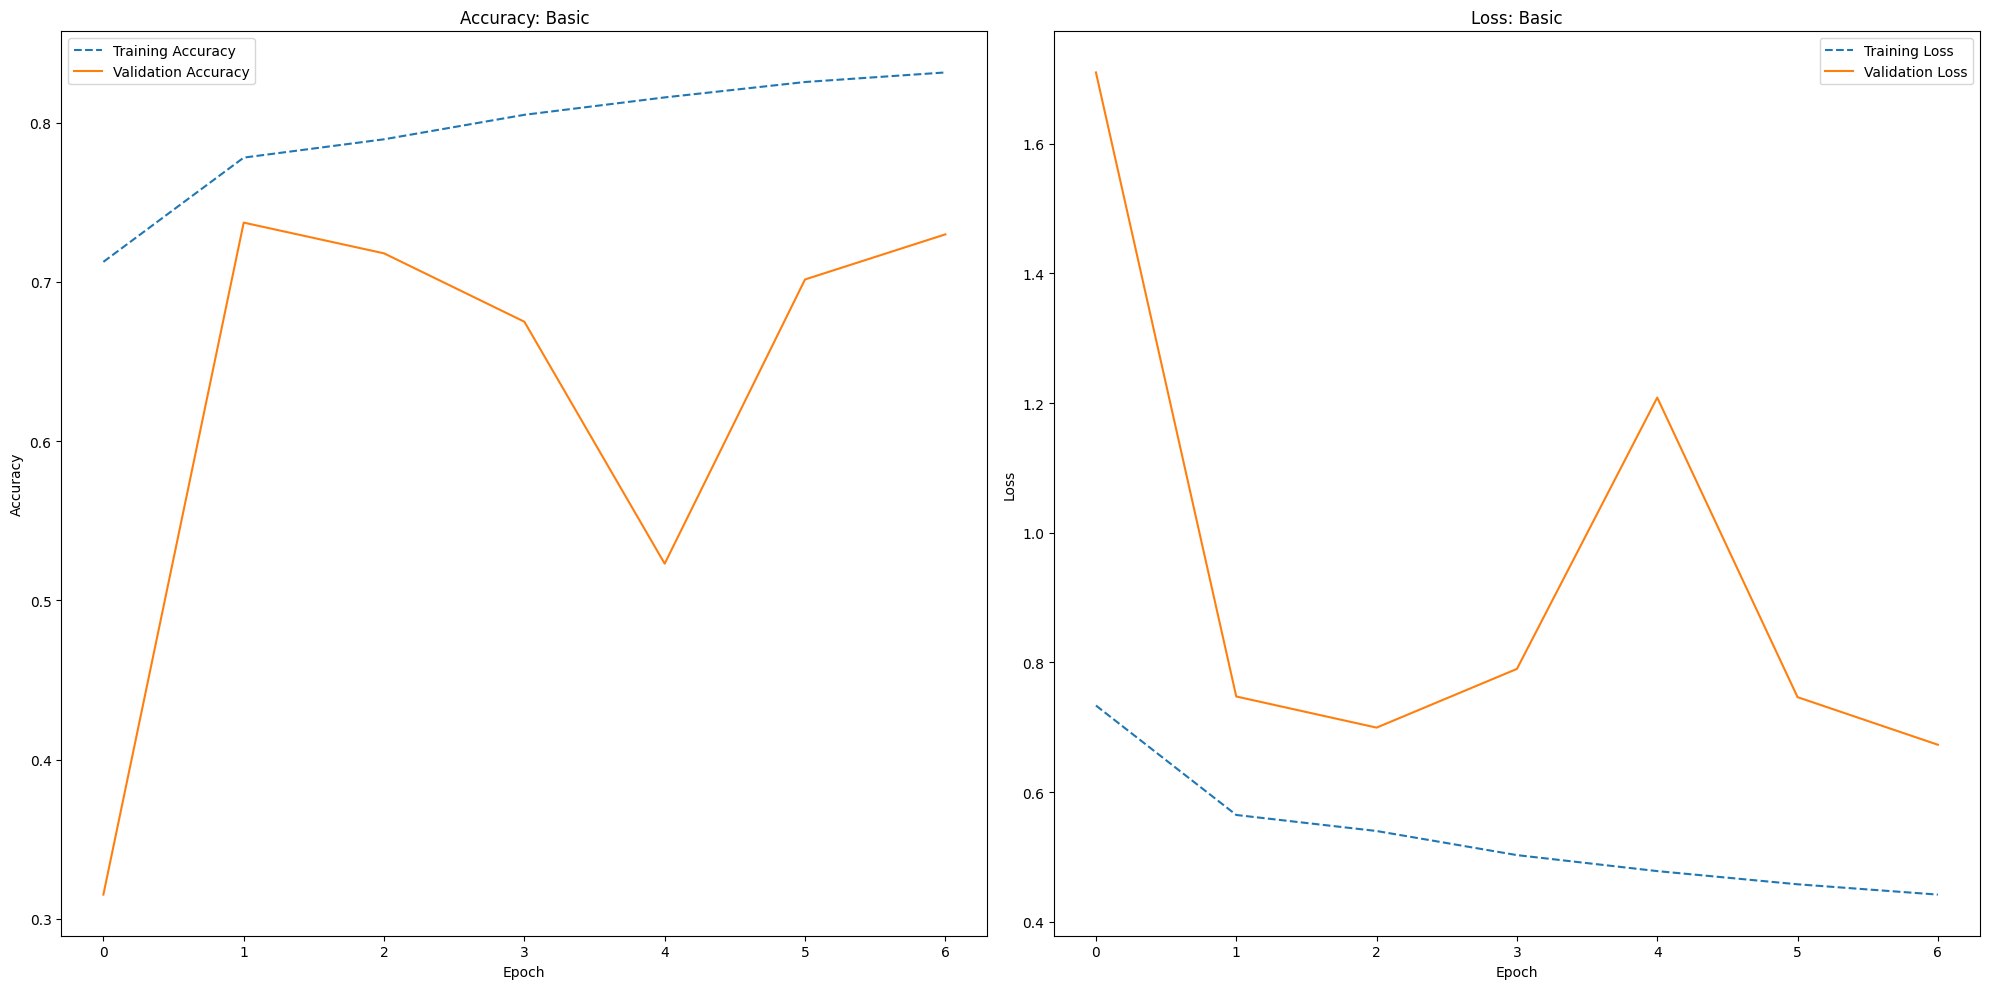

Experiment Basic completed.


Starting experiment: Filters*2
Parameters: filters=[128, 256, 512, 1024, 1024], kernel=(3, 3), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 458s 1s/step - loss: 0.9876 - sparse_categorical_accuracy: 0.6233 - val_loss: 2.4372 - val_sparse_categorical_accuracy: 0.3332
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 341s 1s/step - loss: 0.6435 - sparse_categorical_accuracy: 0.7425 - val_loss: 1.2355 - val_sparse_categorical_accuracy: 0.4613
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.5648 - sparse_categorical_accuracy: 0.7806 - val_loss: 0.7681 - val_sparse_categorical_accuracy: 0.7013
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.5374 - sparse_categorical_accuracy: 0.7926 - val_loss: 0.6539 - val_sparse_categorical_accuracy: 0.7296
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.4940 - sparse_categorical_accuracy: 0.8111 - val_loss: 0.7772 - val_sparse_categorical_accuracy: 0.6740
Epoch 6/7
238/238 ━━━━━━━━━━━

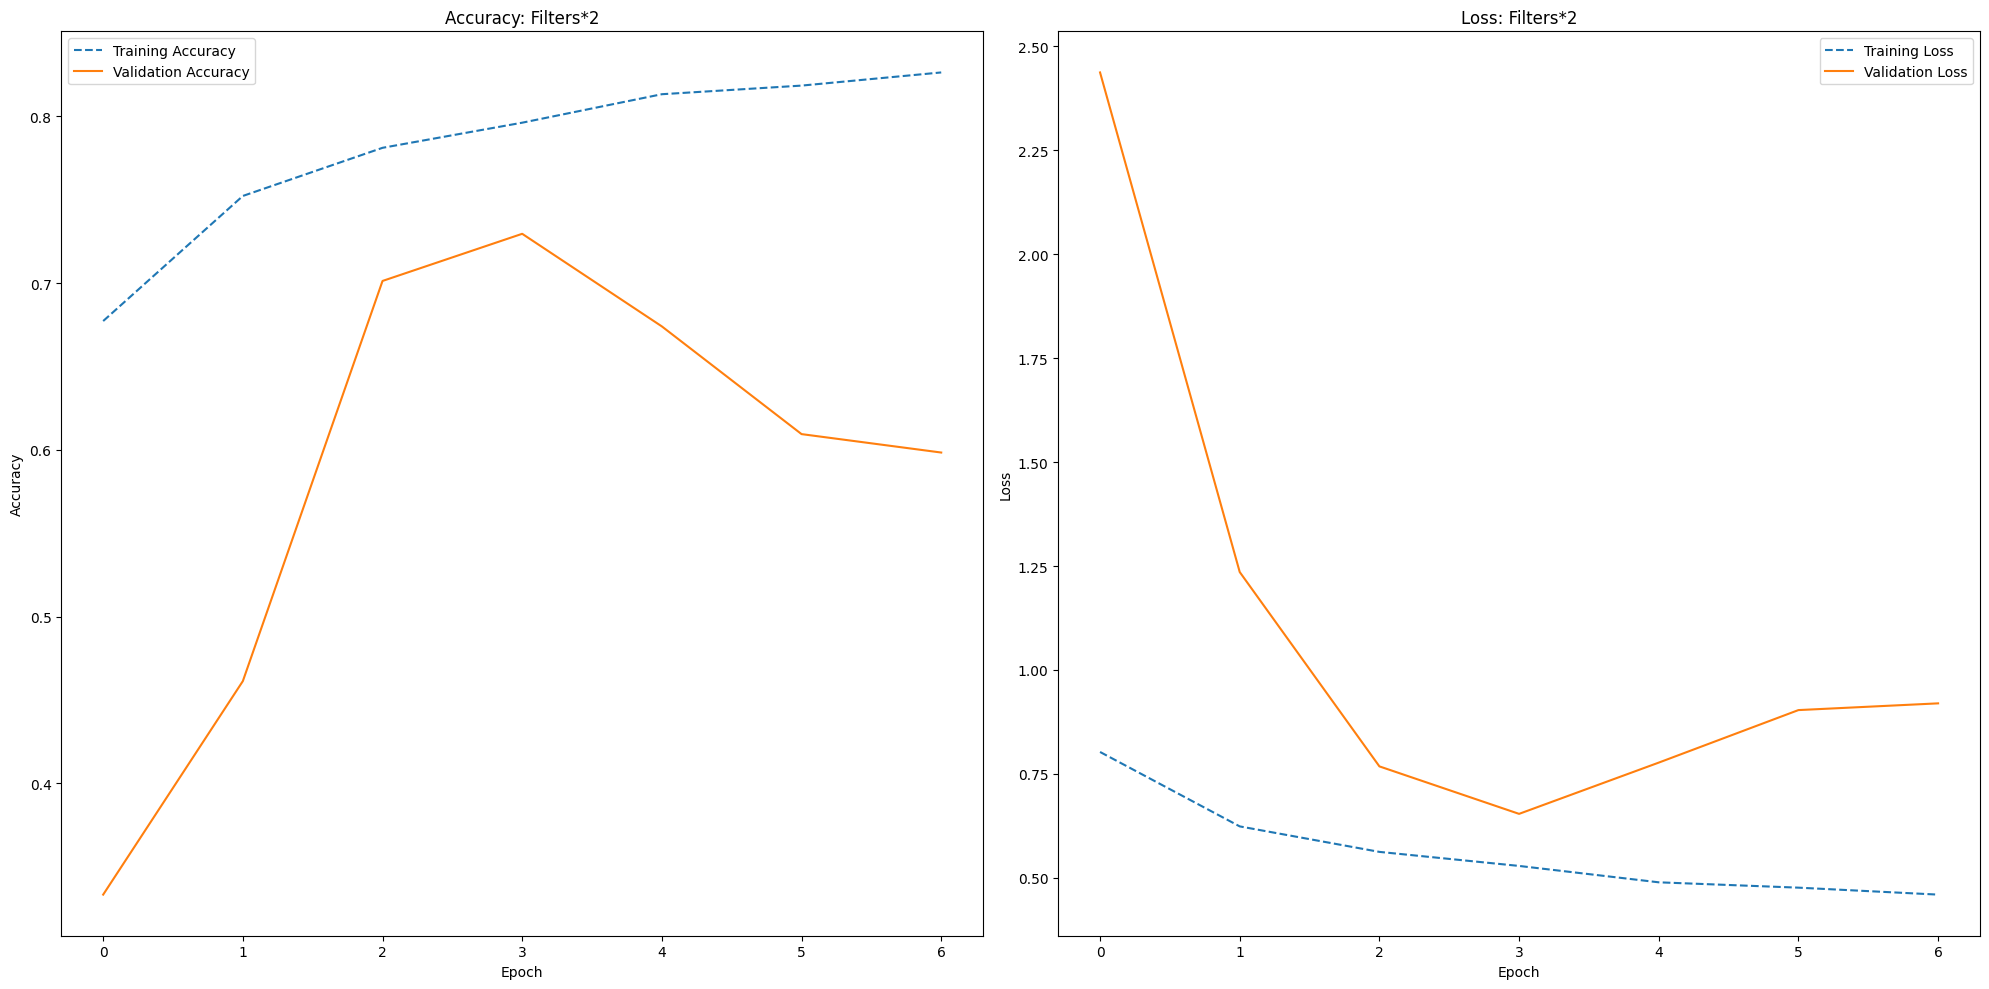

Experiment Filters*2 completed.


Starting experiment: Filters/2
Parameters: filters=[32, 64, 128, 256, 256], kernel=(3, 3), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 92s 234ms/step - loss: 1.1122 - sparse_categorical_accuracy: 0.6256 - val_loss: 0.9567 - val_sparse_categorical_accuracy: 0.7091
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 34s 134ms/step - loss: 0.5950 - sparse_categorical_accuracy: 0.7654 - val_loss: 0.8094 - val_sparse_categorical_accuracy: 0.7144
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 135ms/step - loss: 0.5405 - sparse_categorical_accuracy: 0.7919 - val_loss: 0.8122 - val_sparse_categorical_accuracy: 0.7278
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - loss: 0.5141 - sparse_categorical_accuracy: 0.8025 - val_loss: 0.8196 - val_sparse_categorical_accuracy: 0.7004
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 32s 134ms/step - loss: 0.4818 - sparse_categorical_accuracy: 0.8160 - val_loss: 0.6828 - val_sparse_categorical_accuracy: 0.7193
Epoch 6/7
238/238 ━

FileNotFoundError: [Errno 2] Unable to synchronously create file (unable to open file: name = 'filters/2.weights.h5', errno = 2, error message = 'No such file or directory', flags = 13, o_flags = 242)

In [ ]:
# Цикл обучения
histories = []
for exp in experiments:
    print(f"\nStarting experiment: {exp['name']}")
    print(f"Parameters: filters={exp['filters']}, kernel={exp['kernel_size']}, activation={exp['activation']}")
    # Создание модели
    model = masked_unet(
        class_count=NUM_CLASSES,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        filters_list=exp['filters'],
        kernel_size=exp['kernel_size'],
        activation=exp['activation']
    )
    # Обучение
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=7,
        batch_size=8,
        verbose=1
    )
    # Сохранение истории обучения
    histories.append({
        'name': exp['name'],
        'history': history.history,
        'params': exp
    })
    # Сохранение весов модели
    safe_name = exp['name'].replace(' ', '_').lower()
    weights_filename = f"{safe_name}.weights.h5"
    model.save_weights(weights_filename)
    print(f"Веса в {weights_filename}")
    # Визуализация для текущей модели
    plt.figure(figsize=(20, 10))
    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
    plt.title(f'Accuracy: {exp["name"]}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], '--', label='Training Loss')
    plt.plot(history.history['val_loss'], '-', label='Validation Loss')
    plt.title(f'Loss: {exp["name"]}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Очистка памяти
    del model
    gc.collect()
    print(f"Experiment {exp['name']} completed.\n")


Skipping experiment: Basic

Skipping experiment: Filters*2

Starting experiment: Filters_del_2
Parameters: filters=[32, 64, 128, 256, 256], kernel=(3, 3), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 105s 259ms/step - loss: 1.0511 - sparse_categorical_accuracy: 0.6457 - val_loss: 1.2623 - val_sparse_categorical_accuracy: 0.4432
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - loss: 0.5946 - sparse_categorical_accuracy: 0.7671 - val_loss: 0.8105 - val_sparse_categorical_accuracy: 0.7021
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 33s 140ms/step - loss: 0.5331 - sparse_categorical_accuracy: 0.7939 - val_loss: 0.8094 - val_sparse_categorical_accuracy: 0.6591
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 33s 139ms/step - loss: 0.5030 - sparse_categorical_accuracy: 0.8046 - val_loss: 1.2743 - val_sparse_categorical_accuracy: 0.5463
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 41s 140ms/step - loss: 0.4788 - sparse_categorical_accuracy: 0.8180 - val_loss: 0.6866 - val_sparse_categorical_accu

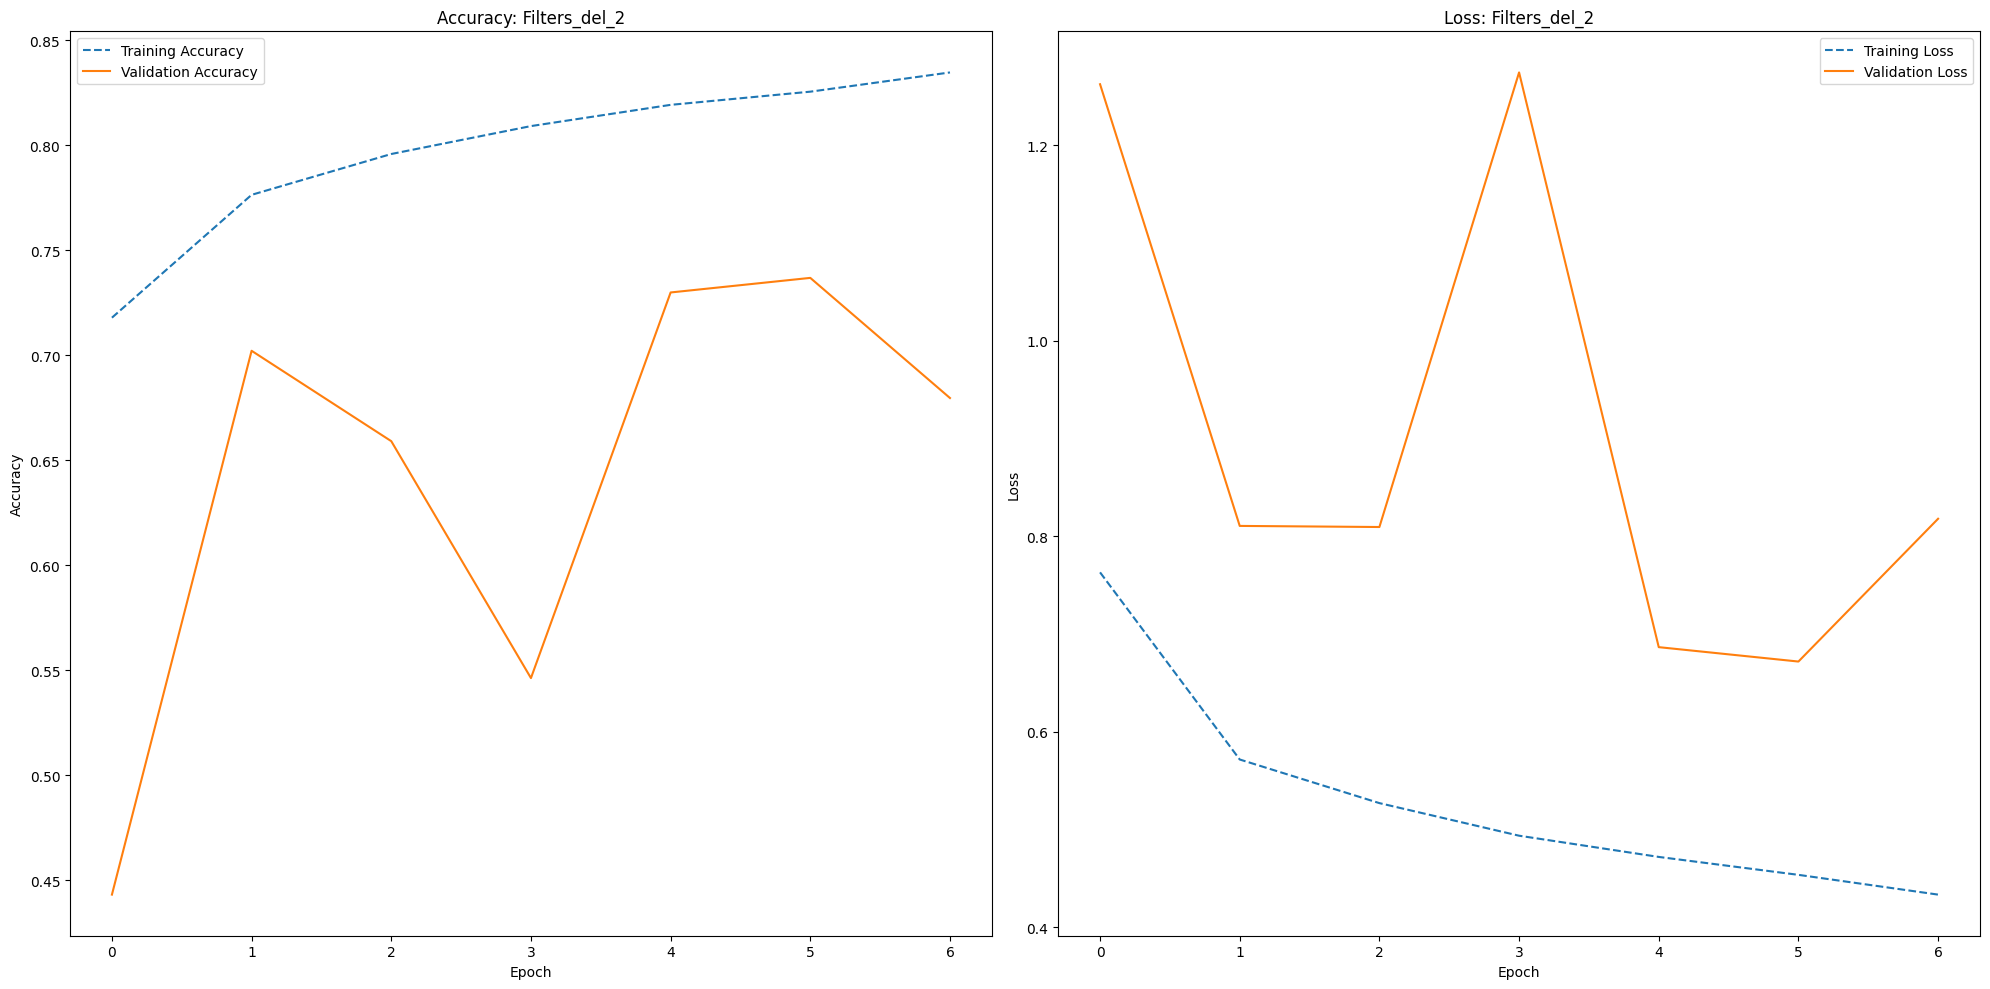

Experiment Filters_del_2 completed.


Starting experiment: Kernel 5, 5
Parameters: filters=[64, 128, 256, 512, 512], kernel=(5, 5), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 329s 1s/step - loss: 0.9243 - sparse_categorical_accuracy: 0.6727 - val_loss: 1.1206 - val_sparse_categorical_accuracy: 0.6907
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 189s 764ms/step - loss: 0.5968 - sparse_categorical_accuracy: 0.7695 - val_loss: 0.7855 - val_sparse_categorical_accuracy: 0.7357
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 203s 769ms/step - loss: 0.5619 - sparse_categorical_accuracy: 0.7818 - val_loss: 0.7839 - val_sparse_categorical_accuracy: 0.6999
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 202s 768ms/step - loss: 0.5131 - sparse_categorical_accuracy: 0.8046 - val_loss: 0.9692 - val_sparse_categorical_accuracy: 0.6564
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 202s 769ms/step - loss: 0.4861 - sparse_categorical_accuracy: 0.8148 - val_loss: 0.6726 - val_sparse_categorical_accuracy: 0.7306
Epoch 6/7


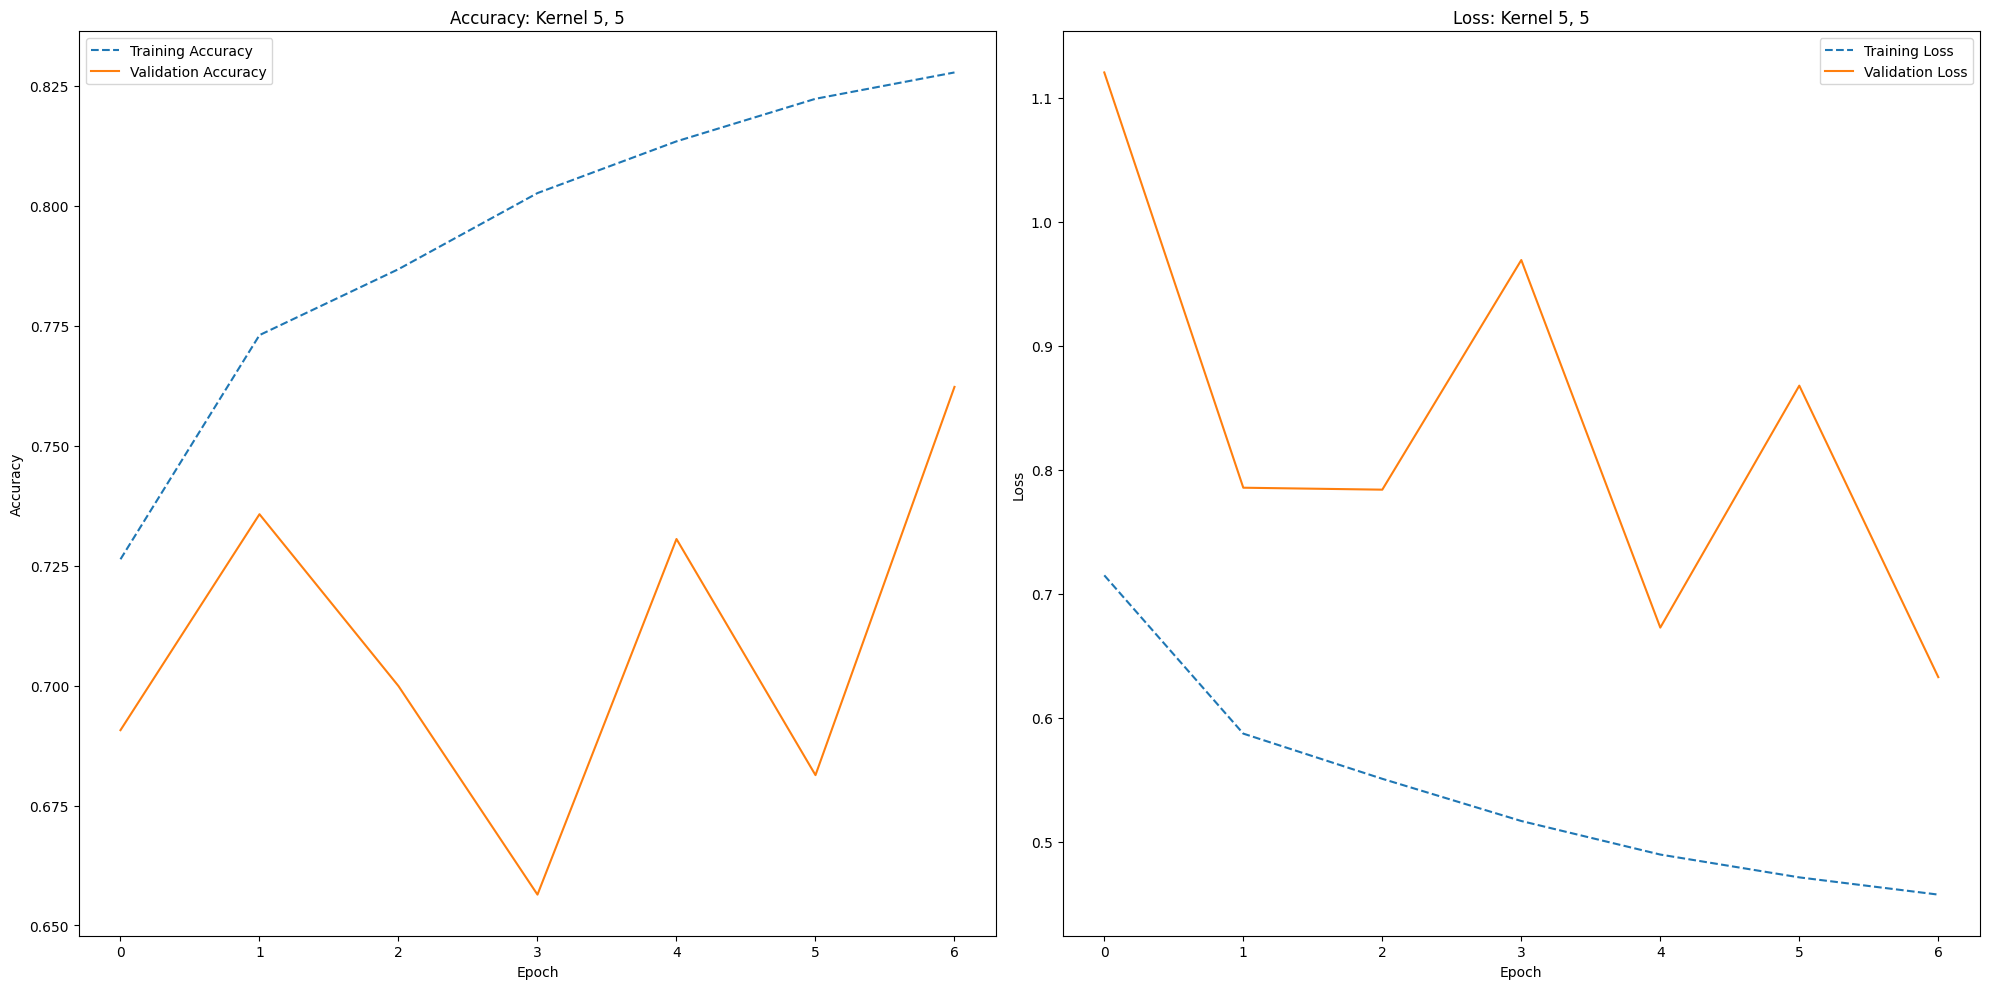

Experiment Kernel 5, 5 completed.


Starting experiment: Kernel 1,1
Parameters: filters=[64, 128, 256, 512, 512], kernel=(1, 1), activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 95s 264ms/step - loss: 1.0385 - sparse_categorical_accuracy: 0.6144 - val_loss: 1.0614 - val_sparse_categorical_accuracy: 0.6417
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 101s 174ms/step - loss: 0.7109 - sparse_categorical_accuracy: 0.6982 - val_loss: 0.9753 - val_sparse_categorical_accuracy: 0.5945
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 176ms/step - loss: 0.6850 - sparse_categorical_accuracy: 0.7129 - val_loss: 0.9113 - val_sparse_categorical_accuracy: 0.5696
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 81s 174ms/step - loss: 0.6871 - sparse_categorical_accuracy: 0.7088 - val_loss: 0.9355 - val_sparse_categorical_accuracy: 0.5700
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 82s 174ms/step - loss: 0.6708 - sparse_categorical_accuracy: 0.7145 - val_loss: 0.9982 - val_sparse_categorical_accuracy: 0.5440
Epoch 6/7
238/

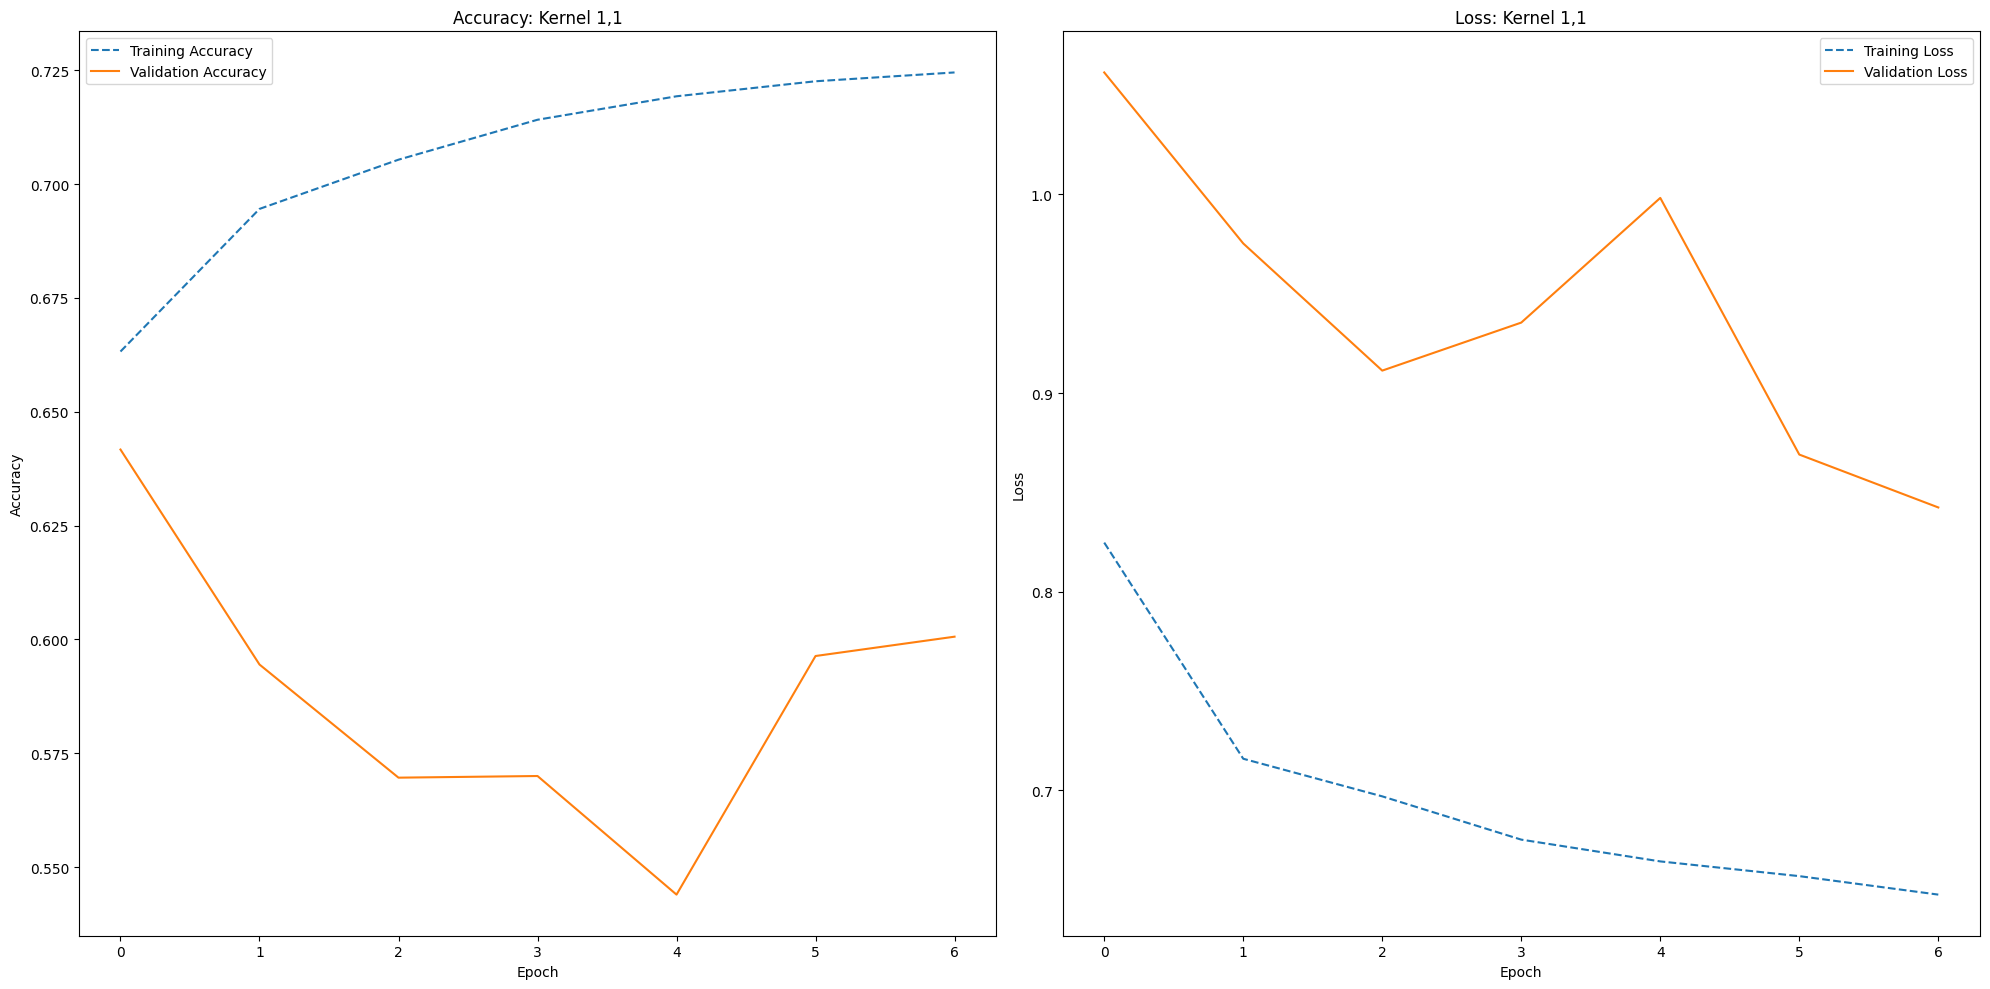

Experiment Kernel 1,1 completed.


Starting experiment: Linear
Parameters: filters=[64, 128, 256, 512, 512], kernel=(3, 3), activation=linear
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 184s 540ms/step - loss: 2.0248 - sparse_categorical_accuracy: 0.4789 - val_loss: 1.5307 - val_sparse_categorical_accuracy: 0.6966
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 127s 402ms/step - loss: 0.7129 - sparse_categorical_accuracy: 0.7197 - val_loss: 0.7479 - val_sparse_categorical_accuracy: 0.7114
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 403ms/step - loss: 0.6638 - sparse_categorical_accuracy: 0.7367 - val_loss: 1.0811 - val_sparse_categorical_accuracy: 0.6743
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 402ms/step - loss: 0.6320 - sparse_categorical_accuracy: 0.7532 - val_loss: 1.1985 - val_sparse_categorical_accuracy: 0.5921
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 403ms/step - loss: 0.6228 - sparse_categorical_accuracy: 0.7587 - val_loss: 1.0307 - val_sparse_categorical_accuracy: 0.6482
Epoch 6/7
238

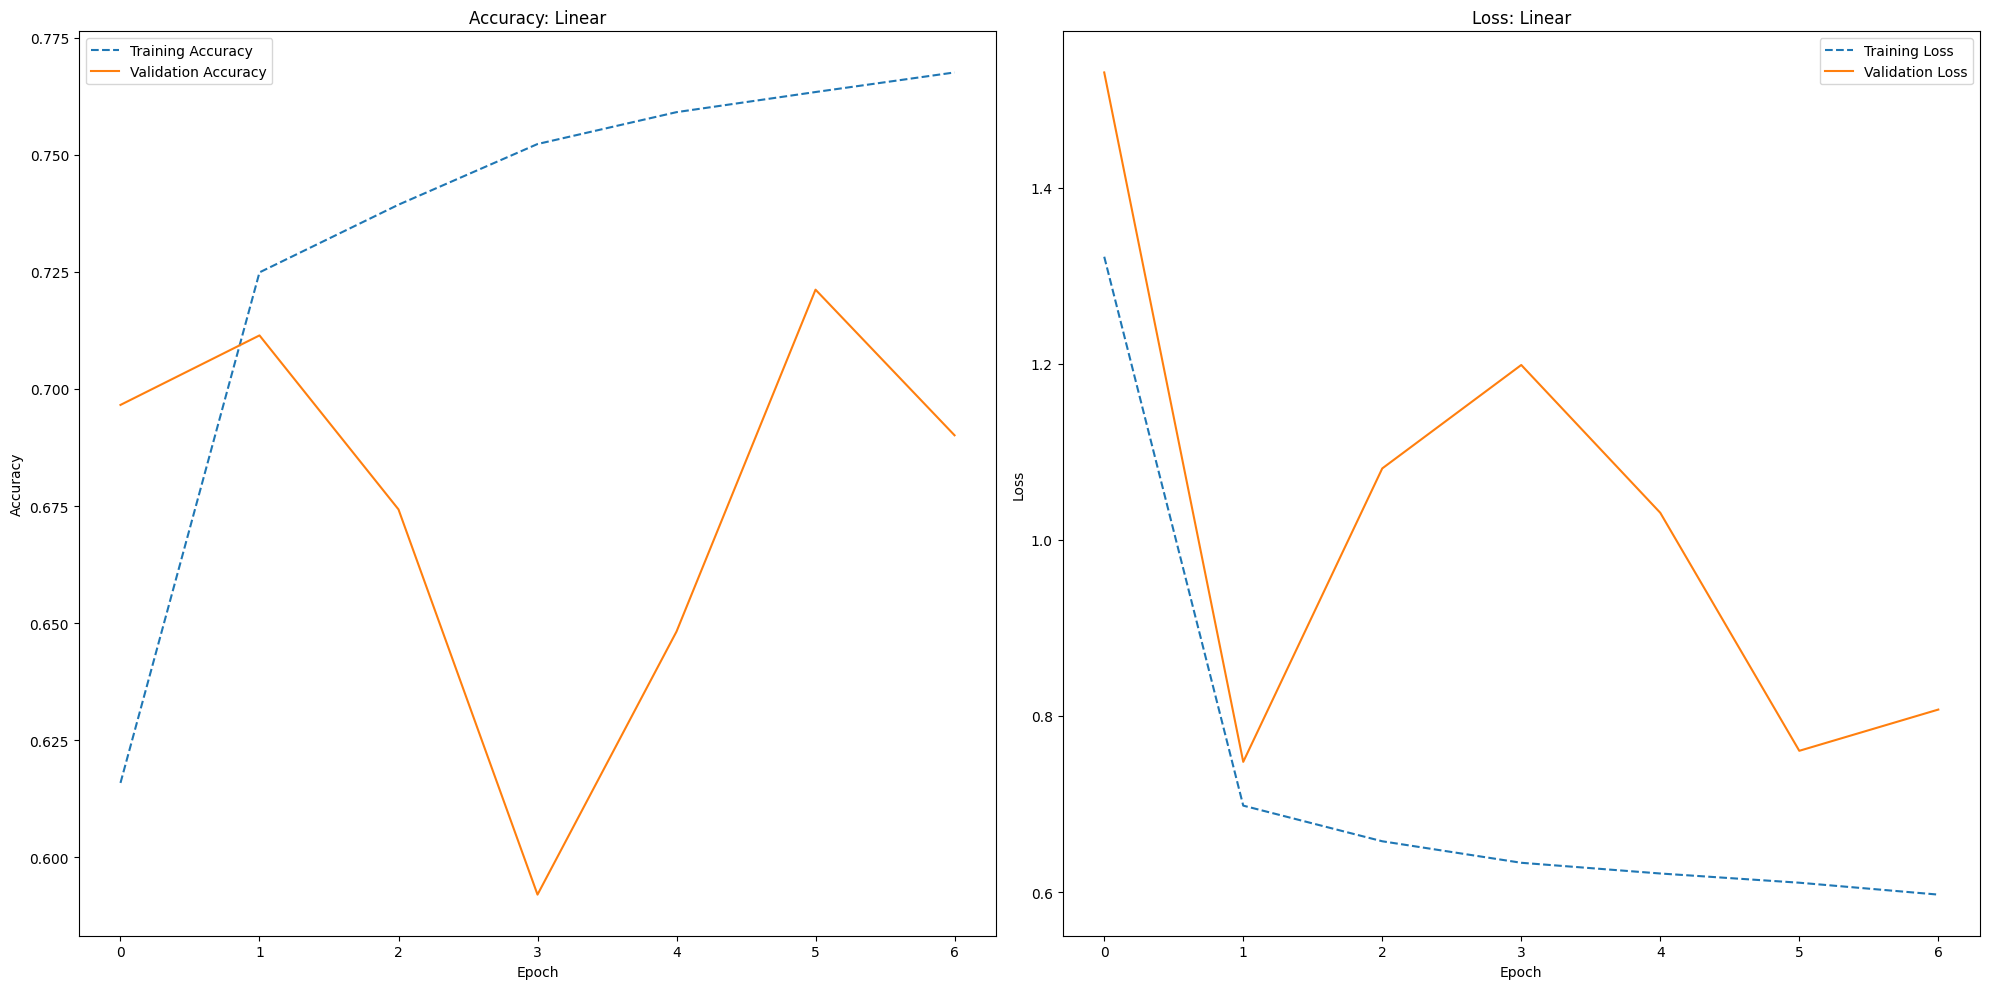

Experiment Linear completed.


Starting experiment: SELU
Parameters: filters=[64, 128, 256, 512, 512], kernel=(3, 3), activation=selu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 139s 478ms/step - loss: 1.9448 - sparse_categorical_accuracy: 0.5028 - val_loss: 3.6080 - val_sparse_categorical_accuracy: 0.3703
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 112s 407ms/step - loss: 0.6713 - sparse_categorical_accuracy: 0.7371 - val_loss: 0.9634 - val_sparse_categorical_accuracy: 0.6023
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 97s 409ms/step - loss: 0.6190 - sparse_categorical_accuracy: 0.7557 - val_loss: 0.7483 - val_sparse_categorical_accuracy: 0.6762
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 408ms/step - loss: 0.5838 - sparse_categorical_accuracy: 0.7704 - val_loss: 0.8144 - val_sparse_categorical_accuracy: 0.6927
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 96s 405ms/step - loss: 0.5712 - sparse_categorical_accuracy: 0.7782 - val_loss: 0.7860 - val_sparse_categorical_accuracy: 0.6787
Epoch 6/7
238/238 ━━━━━

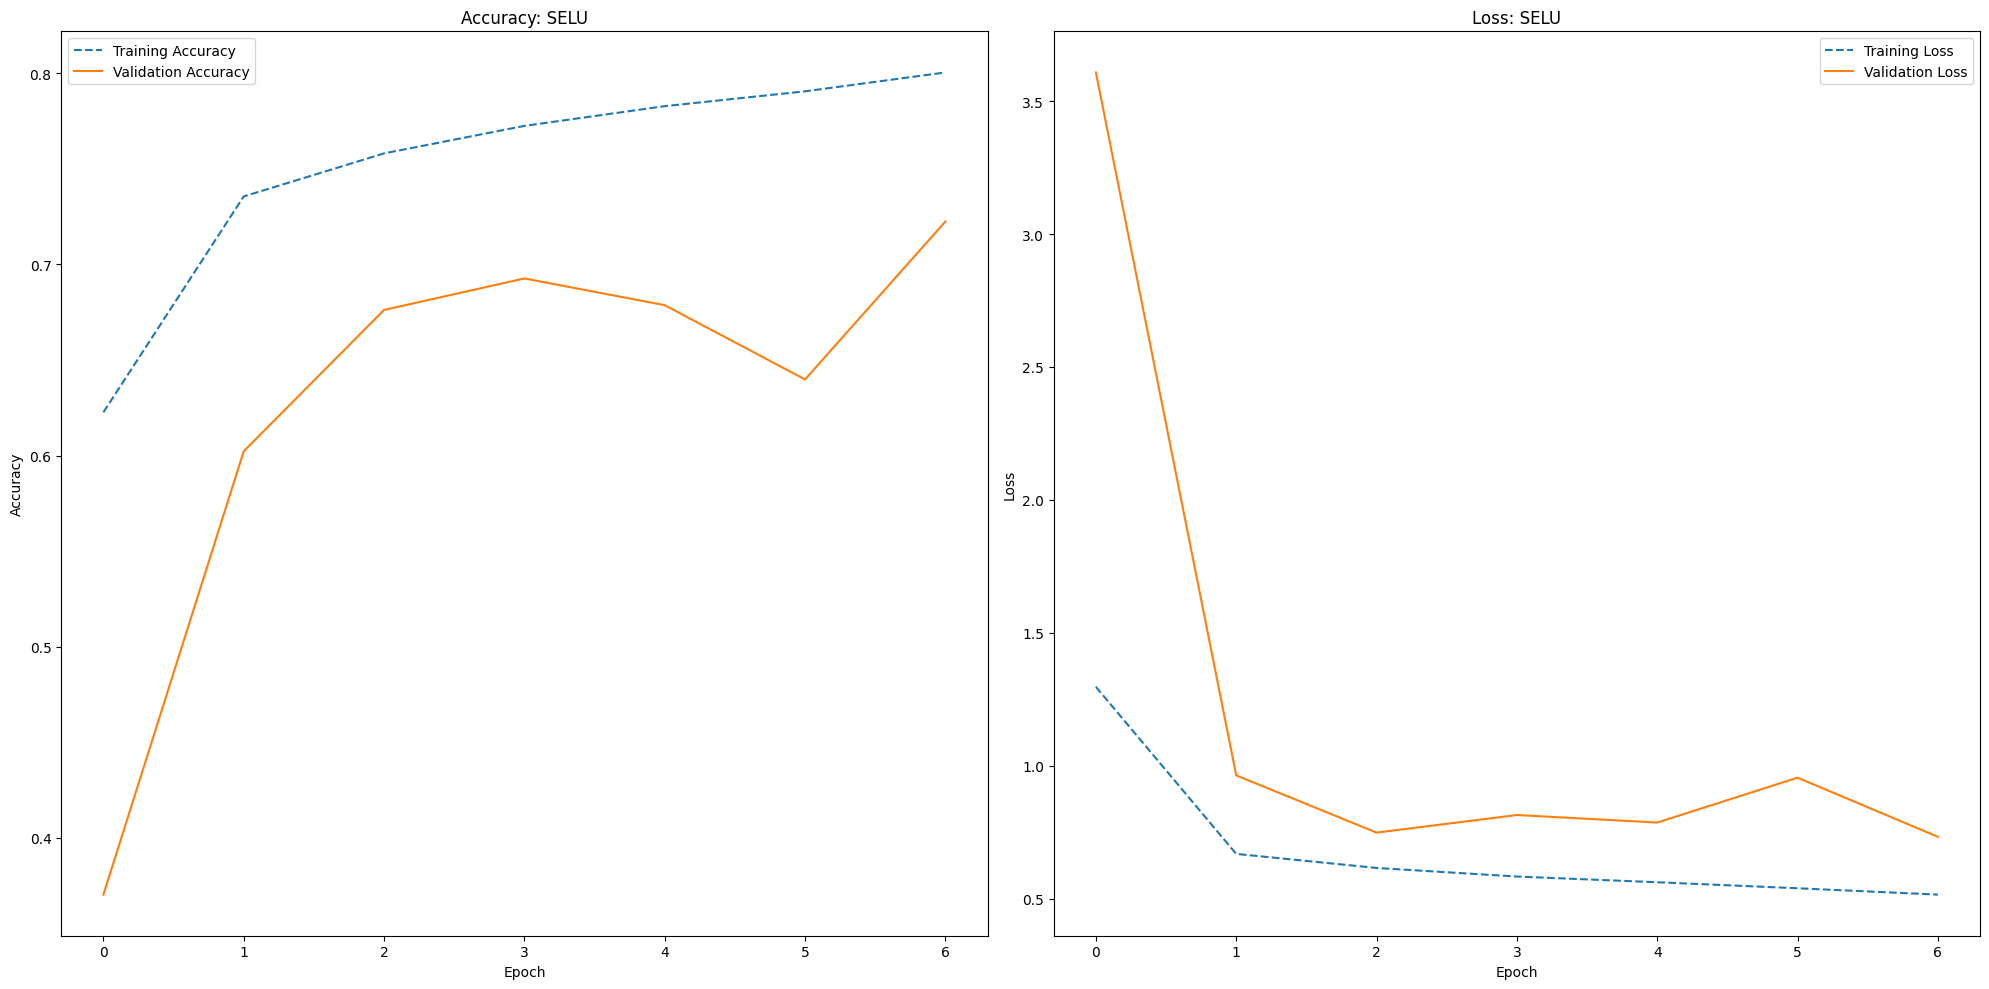

Experiment SELU completed.


Starting experiment: ELU
Parameters: filters=[64, 128, 256, 512, 512], kernel=(3, 3), activation=elu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 138s 470ms/step - loss: 1.1850 - sparse_categorical_accuracy: 0.6267 - val_loss: 1.0097 - val_sparse_categorical_accuracy: 0.7038
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 97s 406ms/step - loss: 0.6472 - sparse_categorical_accuracy: 0.7470 - val_loss: 0.6833 - val_sparse_categorical_accuracy: 0.7293
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 143s 410ms/step - loss: 0.6100 - sparse_categorical_accuracy: 0.7600 - val_loss: 0.8055 - val_sparse_categorical_accuracy: 0.6847
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 410ms/step - loss: 0.5713 - sparse_categorical_accuracy: 0.7773 - val_loss: 0.6886 - val_sparse_categorical_accuracy: 0.7243
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 407ms/step - loss: 0.5626 - sparse_categorical_accuracy: 0.7808 - val_loss: 0.8192 - val_sparse_categorical_accuracy: 0.6428
Epoch 6/7
238/238 ━━━━━━━━

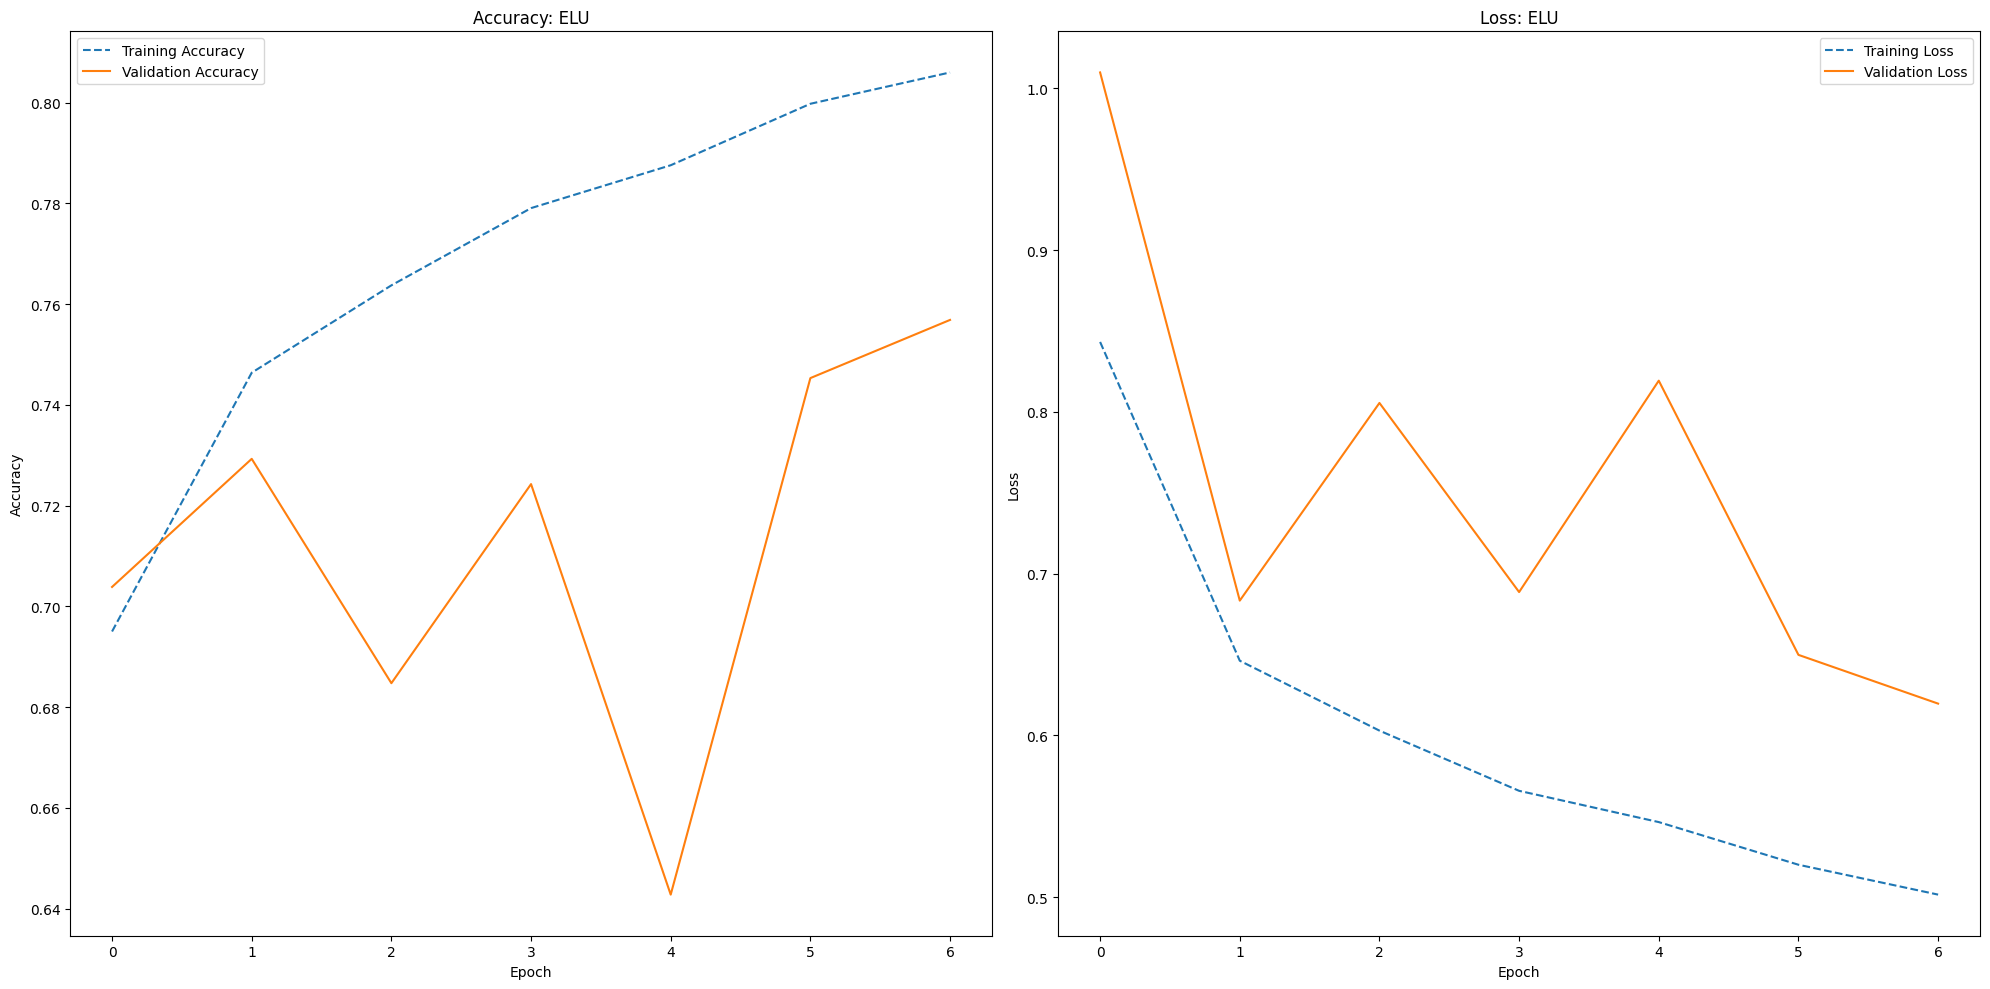

Experiment ELU completed.


Starting experiment: Kernel 5,5 и ELU
Parameters: filters=[64, 128, 256, 512, 512], kernel=(5, 5), activation=elu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 227s 850ms/step - loss: 1.2130 - sparse_categorical_accuracy: 0.6189 - val_loss: 1.3413 - val_sparse_categorical_accuracy: 0.6851
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 185s 778ms/step - loss: 0.6554 - sparse_categorical_accuracy: 0.7434 - val_loss: 0.9197 - val_sparse_categorical_accuracy: 0.6629
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 185s 775ms/step - loss: 0.6066 - sparse_categorical_accuracy: 0.7642 - val_loss: 0.7589 - val_sparse_categorical_accuracy: 0.6850
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 184s 774ms/step - loss: 0.5805 - sparse_categorical_accuracy: 0.7763 - val_loss: 0.9535 - val_sparse_categorical_accuracy: 0.6106
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 184s 775ms/step - loss: 0.5453 - sparse_categorical_accuracy: 0.7929 - val_loss: 0.7684 - val_sparse_categorical_accuracy: 0.7418
Epoch 6/7
238

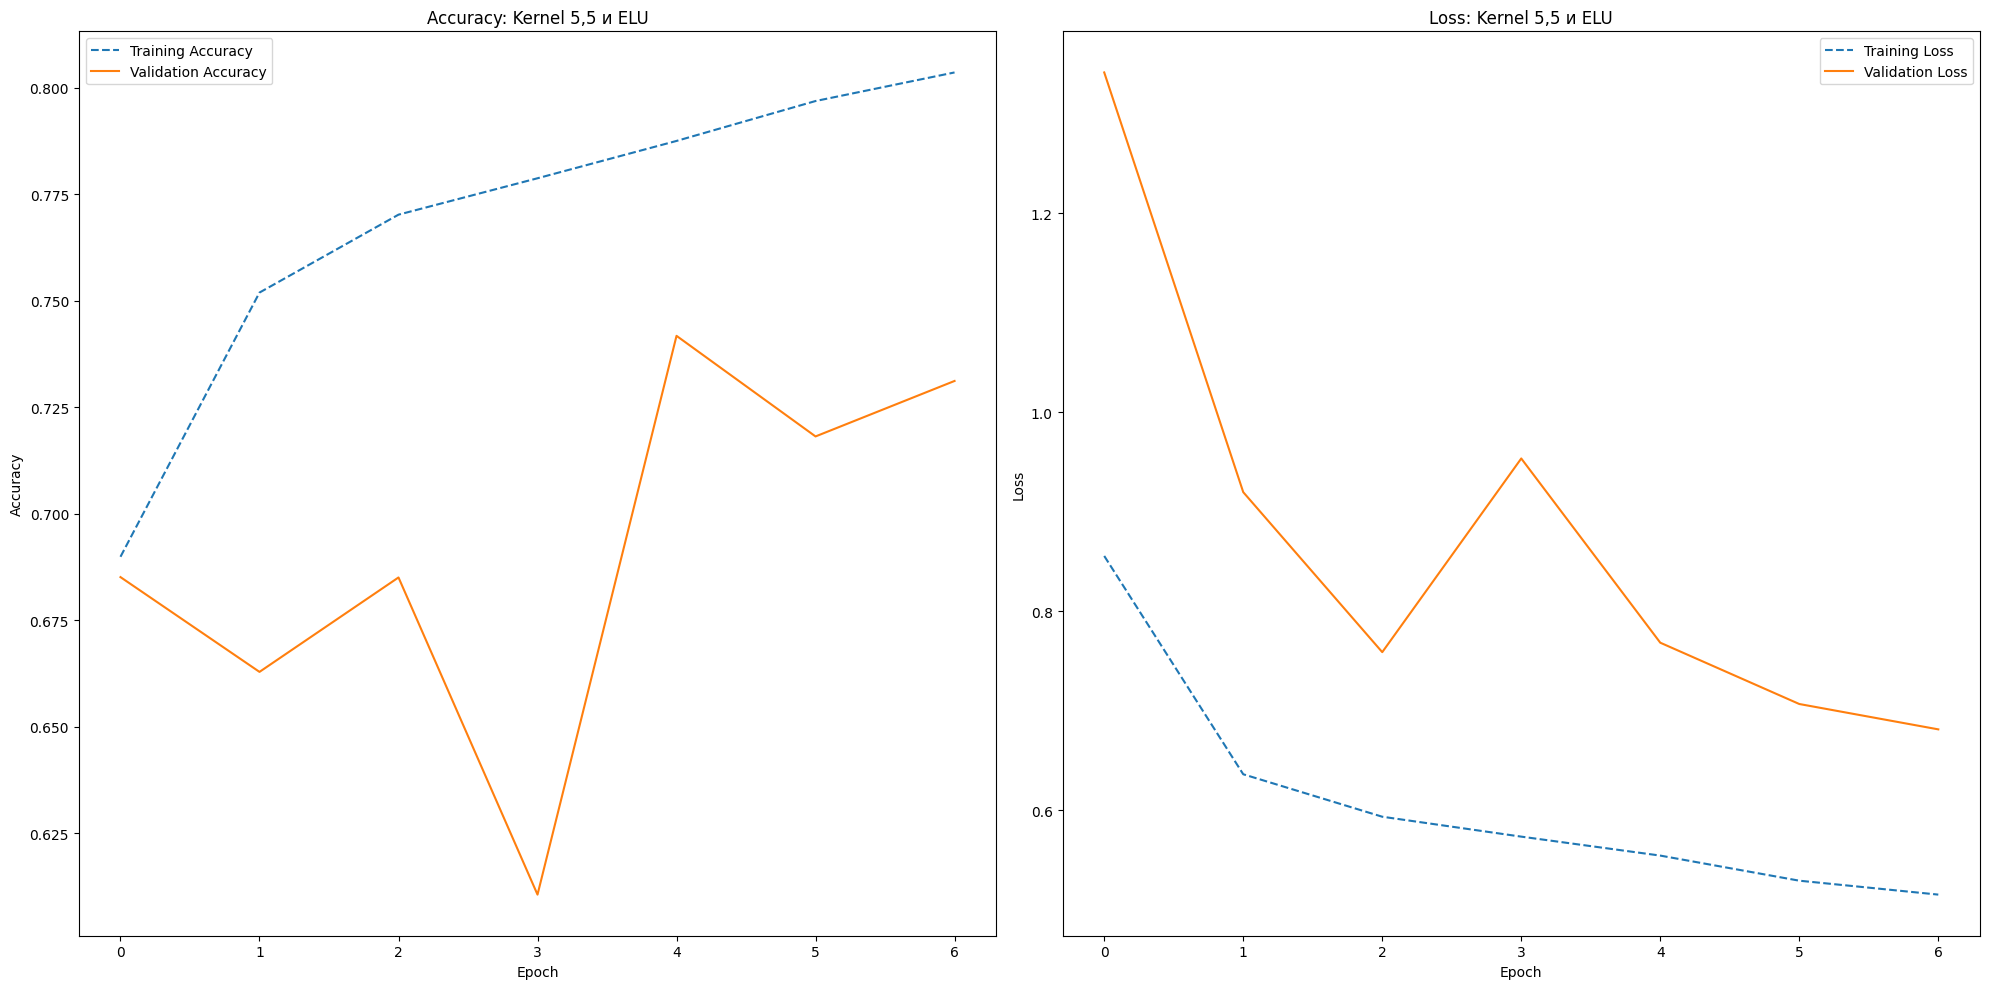

Experiment Kernel 5,5 и ELU completed.


Starting experiment: Filters*2 и SELU
Parameters: filters=[128, 256, 512, 1024, 1024], kernel=(3, 3), activation=selu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 497s 2s/step - loss: 1.9126 - sparse_categorical_accuracy: 0.5131 - val_loss: 1.3178 - val_sparse_categorical_accuracy: 0.7065
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - loss: 0.7109 - sparse_categorical_accuracy: 0.7145 - val_loss: 1.2666 - val_sparse_categorical_accuracy: 0.6895
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 314s 1s/step - loss: 0.6311 - sparse_categorical_accuracy: 0.7544 - val_loss: 0.8511 - val_sparse_categorical_accuracy: 0.6991
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 323s 1s/step - loss: 0.5920 - sparse_categorical_accuracy: 0.7685 - val_loss: 0.7148 - val_sparse_categorical_accuracy: 0.7434
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 322s 1s/step - loss: 0.5734 - sparse_categorical_accuracy: 0.7763 - val_loss: 0.8408 - val_sparse_categorical_accuracy: 0.7224
Epoch 6/7
2

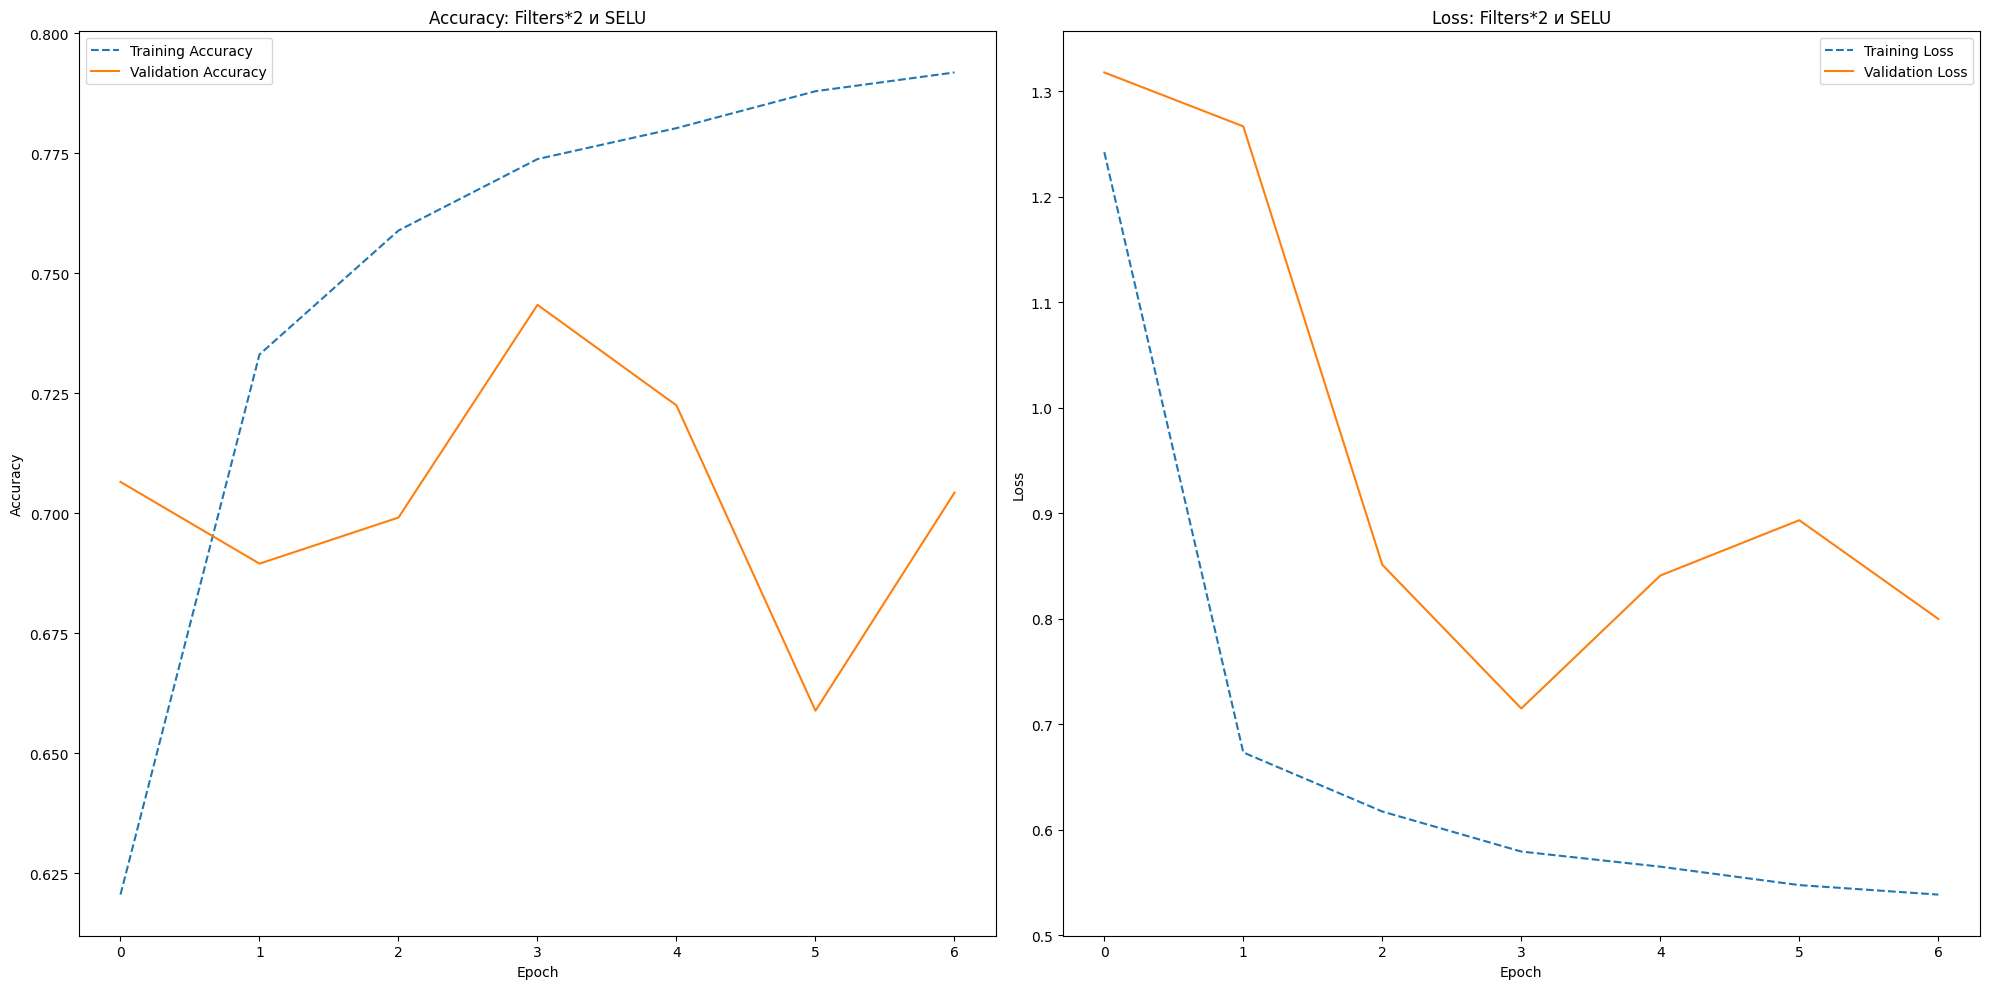

Experiment Filters*2 и SELU completed.


Starting experiment: Kernel_sizes
Parameters: filters=[64, 128, 256, 512, 512], kernel=[(5, 5), (3, 3), (3, 3), (1, 1), (1, 1)], activation=relu
Epoch 1/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 485ms/step - loss: 0.9815 - sparse_categorical_accuracy: 0.6415 - val_loss: 2.6265 - val_sparse_categorical_accuracy: 0.2799
Epoch 2/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 101s 425ms/step - loss: 0.7020 - sparse_categorical_accuracy: 0.7157 - val_loss: 1.2116 - val_sparse_categorical_accuracy: 0.3582
Epoch 3/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 425ms/step - loss: 0.6448 - sparse_categorical_accuracy: 0.7373 - val_loss: 1.0172 - val_sparse_categorical_accuracy: 0.6622
Epoch 4/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 141s 422ms/step - loss: 0.6032 - sparse_categorical_accuracy: 0.7556 - val_loss: 1.6782 - val_sparse_categorical_accuracy: 0.3827
Epoch 5/7
238/238 ━━━━━━━━━━━━━━━━━━━━ 142s 422ms/step - loss: 0.5709 - sparse_categorical_accuracy: 0.7711 - val_loss: 0.8073 - val_spars

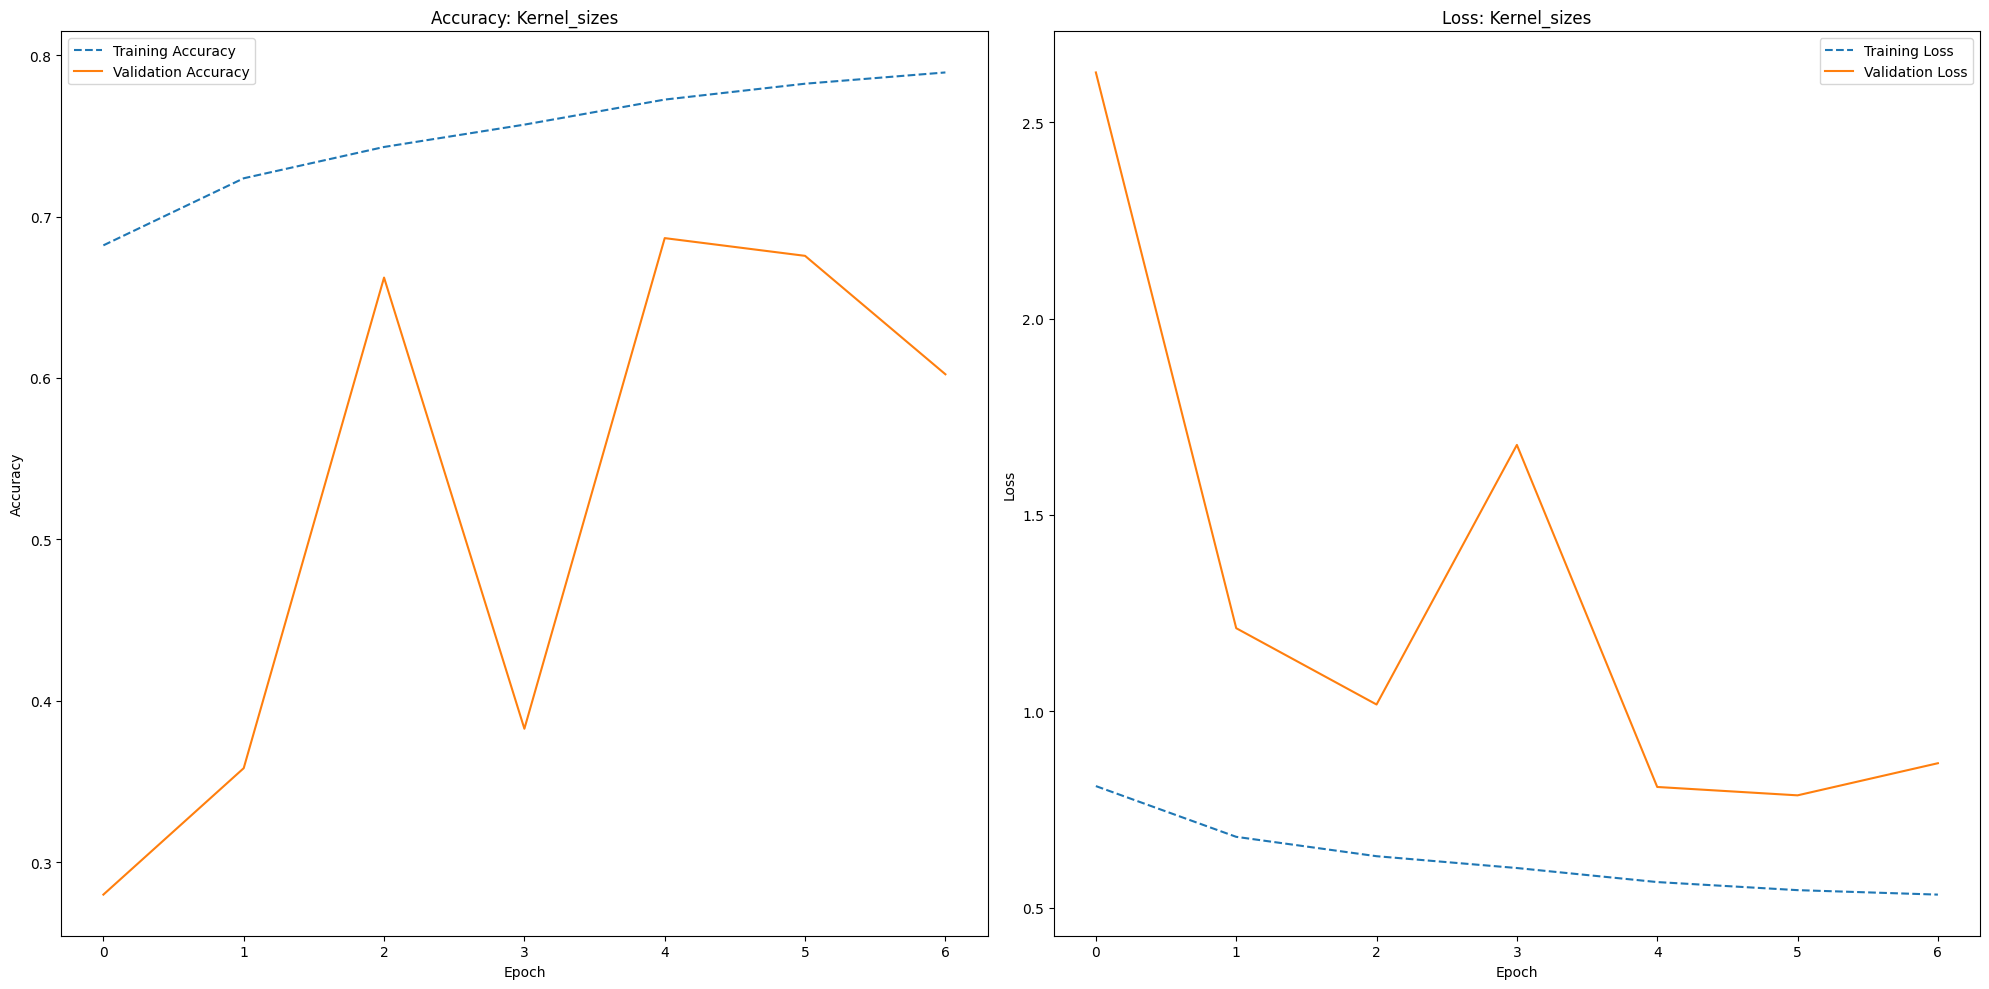

Experiment Kernel_sizes completed.



In [ ]:
# Если не все обучились. В списке - модели для пропуска
skip_list = ["Basic", "Filters*2"]

# Цикл обучения
histories = []
for exp in experiments:
    if exp['name'] in skip_list:
        print(f"\nSkipping experiment: {exp['name']}")
        continue
    print(f"\nStarting experiment: {exp['name']}")
    print(f"Parameters: filters={exp['filters']}, kernel={exp['kernel_size']}, activation={exp['activation']}")
    # Создание модели
    model = masked_unet(
        class_count=NUM_CLASSES,
        input_shape=(IMG_WIDTH, IMG_HEIGHT, 3),
        filters_list=exp['filters'],
        kernel_size=exp['kernel_size'],
        activation=exp['activation']
    )
    # Обучение
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=7,
        batch_size=8,
        verbose=1
    )
    # Сохранение истории обучения
    histories.append({
        'name': exp['name'],
        'history': history.history,
        'params': exp
    })
    # Сохранение весов модели
    safe_name = exp['name'].replace(' ', '_').lower()
    weights_filename = f"{safe_name}.weights.h5"
    model.save_weights(weights_filename)
    print(f"Веса в {weights_filename}")
    # Визуализация для текущей модели
    plt.figure(figsize=(20, 10))
    # График точности
    plt.subplot(1, 2, 1)
    plt.plot(history.history['sparse_categorical_accuracy'], '--', label='Training Accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], '-', label='Validation Accuracy')
    plt.title(f'Accuracy: {exp["name"]}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    # График потерь
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], '--', label='Training Loss')
    plt.plot(history.history['val_loss'], '-', label='Validation Loss')
    plt.title(f'Loss: {exp["name"]}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Очистка памяти
    del model
    gc.collect()
    print(f"Experiment {exp['name']} completed.\n")